# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

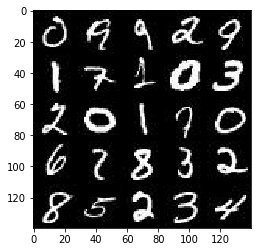

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

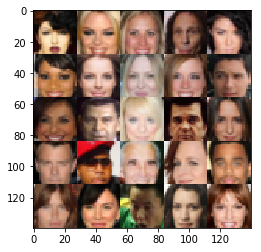

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='real_input')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64 now
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='SAME')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='SAME')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256 now

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, [-1, 7, 7, 512])
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='SAME')
        # 28x28x3
        
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1.-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
class DCGAN:
    def __init__(self, image_width=28, image_height=28, image_channels=1, z_dim=100, out_channel_dim=1, beta1=0.5):
        #tf.reset_default_graph()
        
        # placeholder
        self.input_real, self.input_z, self.learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
        
        # loss
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, out_channel_dim)
        
        # optimizer
        self.d_train_opt, self.g_train_opt = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    net = DCGAN(image_width=data_shape[1], image_height=data_shape[2], image_channels=data_shape[3],
               z_dim=z_dim, out_channel_dim=data_shape[3], beta1=beta1)
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps = steps + 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # The reason for multipling the batch image values by 2 is that the generator returns
                # values in the range [-1, 1], while the batch_images has values in the range [-0.5, 0.5].
                batch_images = batch_images * 2.
                
                # Run optimizers
                _ = sess.run(net.d_train_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z, net.learning_rate: learning_rate})
                _ = sess.run(net.g_train_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z, net.learning_rate: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 16, net.input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7066... Generator Loss: 0.3725
Epoch 1/2... Discriminator Loss: 3.5550... Generator Loss: 0.0616
Epoch 1/2... Discriminator Loss: 2.2241... Generator Loss: 0.2017
Epoch 1/2... Discriminator Loss: 2.1266... Generator Loss: 0.2298
Epoch 1/2... Discriminator Loss: 2.0191... Generator Loss: 0.2366
Epoch 1/2... Discriminator Loss: 1.5380... Generator Loss: 0.8658
Epoch 1/2... Discriminator Loss: 1.6625... Generator Loss: 1.2294
Epoch 1/2... Discriminator Loss: 1.4520... Generator Loss: 1.2257
Epoch 1/2... Discriminator Loss: 1.4674... Generator Loss: 1.0711
Epoch 1/2... Discriminator Loss: 1.4283... Generator Loss: 1.0383


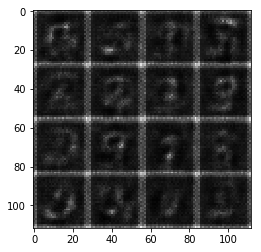

Epoch 1/2... Discriminator Loss: 1.4833... Generator Loss: 1.3408
Epoch 1/2... Discriminator Loss: 1.3676... Generator Loss: 0.9069
Epoch 1/2... Discriminator Loss: 1.4262... Generator Loss: 0.5268
Epoch 1/2... Discriminator Loss: 1.8395... Generator Loss: 0.2808
Epoch 1/2... Discriminator Loss: 1.5600... Generator Loss: 0.3892
Epoch 1/2... Discriminator Loss: 1.5234... Generator Loss: 0.4436
Epoch 1/2... Discriminator Loss: 1.3614... Generator Loss: 0.5050
Epoch 1/2... Discriminator Loss: 1.3137... Generator Loss: 0.5727
Epoch 1/2... Discriminator Loss: 1.3621... Generator Loss: 0.5203
Epoch 1/2... Discriminator Loss: 1.2326... Generator Loss: 0.6491


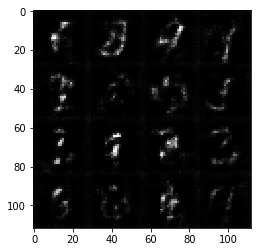

Epoch 1/2... Discriminator Loss: 0.9956... Generator Loss: 1.0981
Epoch 1/2... Discriminator Loss: 1.2065... Generator Loss: 1.2073
Epoch 1/2... Discriminator Loss: 1.1323... Generator Loss: 1.2191
Epoch 1/2... Discriminator Loss: 1.5465... Generator Loss: 0.4207
Epoch 1/2... Discriminator Loss: 1.5790... Generator Loss: 0.3879
Epoch 1/2... Discriminator Loss: 1.4482... Generator Loss: 0.4609
Epoch 1/2... Discriminator Loss: 1.2335... Generator Loss: 0.6517
Epoch 1/2... Discriminator Loss: 1.5003... Generator Loss: 0.4611
Epoch 1/2... Discriminator Loss: 1.2075... Generator Loss: 0.6954
Epoch 1/2... Discriminator Loss: 1.6455... Generator Loss: 0.3553


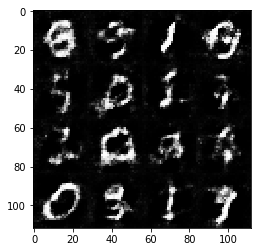

Epoch 1/2... Discriminator Loss: 1.7338... Generator Loss: 0.3344
Epoch 1/2... Discriminator Loss: 1.6323... Generator Loss: 0.3605
Epoch 1/2... Discriminator Loss: 1.6132... Generator Loss: 0.3731
Epoch 1/2... Discriminator Loss: 1.4320... Generator Loss: 0.4715
Epoch 1/2... Discriminator Loss: 1.5755... Generator Loss: 0.4149
Epoch 1/2... Discriminator Loss: 1.5368... Generator Loss: 0.4094
Epoch 1/2... Discriminator Loss: 1.5549... Generator Loss: 0.3972
Epoch 1/2... Discriminator Loss: 1.1508... Generator Loss: 0.9177
Epoch 1/2... Discriminator Loss: 1.3580... Generator Loss: 1.3496
Epoch 1/2... Discriminator Loss: 1.3006... Generator Loss: 0.7163


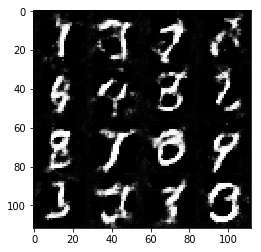

Epoch 1/2... Discriminator Loss: 1.2167... Generator Loss: 1.0920
Epoch 1/2... Discriminator Loss: 1.1995... Generator Loss: 0.9348
Epoch 1/2... Discriminator Loss: 1.1845... Generator Loss: 1.5488
Epoch 1/2... Discriminator Loss: 1.3195... Generator Loss: 0.5924
Epoch 1/2... Discriminator Loss: 1.7035... Generator Loss: 0.3412
Epoch 1/2... Discriminator Loss: 1.3649... Generator Loss: 0.5432
Epoch 1/2... Discriminator Loss: 1.2497... Generator Loss: 0.6174
Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 0.8815
Epoch 1/2... Discriminator Loss: 1.2821... Generator Loss: 1.2527
Epoch 1/2... Discriminator Loss: 1.3896... Generator Loss: 0.5340


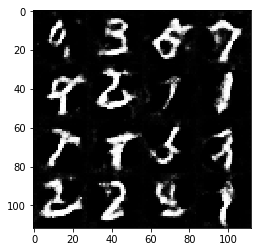

Epoch 1/2... Discriminator Loss: 1.3287... Generator Loss: 0.5507
Epoch 1/2... Discriminator Loss: 1.1187... Generator Loss: 1.0128
Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 1.4446
Epoch 1/2... Discriminator Loss: 1.1908... Generator Loss: 1.3776
Epoch 1/2... Discriminator Loss: 1.2415... Generator Loss: 0.8727
Epoch 1/2... Discriminator Loss: 1.4918... Generator Loss: 1.6887
Epoch 1/2... Discriminator Loss: 1.1781... Generator Loss: 1.3360
Epoch 1/2... Discriminator Loss: 1.2574... Generator Loss: 0.6585
Epoch 1/2... Discriminator Loss: 1.4895... Generator Loss: 0.4663
Epoch 1/2... Discriminator Loss: 1.2781... Generator Loss: 0.6299


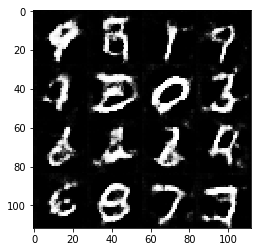

Epoch 1/2... Discriminator Loss: 1.2116... Generator Loss: 1.2151
Epoch 1/2... Discriminator Loss: 1.1863... Generator Loss: 0.8786
Epoch 1/2... Discriminator Loss: 1.1323... Generator Loss: 0.9610
Epoch 1/2... Discriminator Loss: 1.5488... Generator Loss: 0.3986
Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 0.5738
Epoch 1/2... Discriminator Loss: 1.4387... Generator Loss: 0.4656
Epoch 1/2... Discriminator Loss: 1.2909... Generator Loss: 0.6176
Epoch 1/2... Discriminator Loss: 1.2944... Generator Loss: 0.5926
Epoch 1/2... Discriminator Loss: 1.2363... Generator Loss: 0.6579
Epoch 1/2... Discriminator Loss: 1.4363... Generator Loss: 0.5001


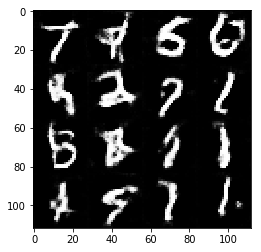

Epoch 1/2... Discriminator Loss: 1.3082... Generator Loss: 0.5412
Epoch 1/2... Discriminator Loss: 1.1567... Generator Loss: 0.7443
Epoch 1/2... Discriminator Loss: 1.3893... Generator Loss: 0.5039
Epoch 1/2... Discriminator Loss: 1.6027... Generator Loss: 0.3885
Epoch 1/2... Discriminator Loss: 1.1342... Generator Loss: 0.7626
Epoch 1/2... Discriminator Loss: 1.3070... Generator Loss: 0.5737
Epoch 1/2... Discriminator Loss: 1.0008... Generator Loss: 1.2727
Epoch 1/2... Discriminator Loss: 1.1108... Generator Loss: 1.0459
Epoch 1/2... Discriminator Loss: 1.1548... Generator Loss: 1.0995
Epoch 1/2... Discriminator Loss: 1.1137... Generator Loss: 0.8103


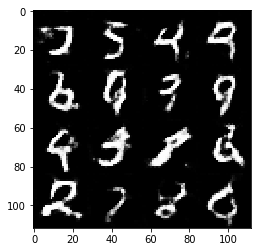

Epoch 1/2... Discriminator Loss: 1.1101... Generator Loss: 0.8438
Epoch 1/2... Discriminator Loss: 1.1446... Generator Loss: 1.5273
Epoch 1/2... Discriminator Loss: 1.3355... Generator Loss: 1.7211
Epoch 1/2... Discriminator Loss: 1.2038... Generator Loss: 0.7345
Epoch 1/2... Discriminator Loss: 1.4189... Generator Loss: 0.5395
Epoch 1/2... Discriminator Loss: 1.4742... Generator Loss: 0.4522
Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 0.7795
Epoch 1/2... Discriminator Loss: 1.1120... Generator Loss: 0.7593
Epoch 1/2... Discriminator Loss: 1.2822... Generator Loss: 1.3571
Epoch 1/2... Discriminator Loss: 1.0444... Generator Loss: 0.9811


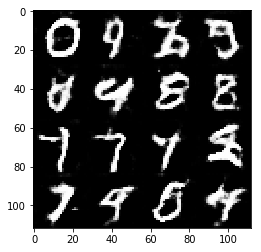

Epoch 1/2... Discriminator Loss: 1.2602... Generator Loss: 0.6305
Epoch 1/2... Discriminator Loss: 1.0800... Generator Loss: 0.8062
Epoch 1/2... Discriminator Loss: 0.9785... Generator Loss: 1.0339
Epoch 2/2... Discriminator Loss: 1.5550... Generator Loss: 1.7556
Epoch 2/2... Discriminator Loss: 1.1341... Generator Loss: 0.7903
Epoch 2/2... Discriminator Loss: 1.1198... Generator Loss: 0.7015
Epoch 2/2... Discriminator Loss: 1.0072... Generator Loss: 0.8401
Epoch 2/2... Discriminator Loss: 1.0710... Generator Loss: 1.0863
Epoch 2/2... Discriminator Loss: 1.0617... Generator Loss: 1.2006
Epoch 2/2... Discriminator Loss: 1.1664... Generator Loss: 0.7165


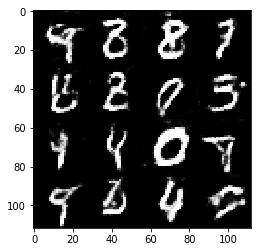

Epoch 2/2... Discriminator Loss: 1.2296... Generator Loss: 0.6043
Epoch 2/2... Discriminator Loss: 0.9626... Generator Loss: 1.0802
Epoch 2/2... Discriminator Loss: 1.5309... Generator Loss: 0.4203
Epoch 2/2... Discriminator Loss: 1.1409... Generator Loss: 0.7132
Epoch 2/2... Discriminator Loss: 1.0560... Generator Loss: 0.8562
Epoch 2/2... Discriminator Loss: 0.8988... Generator Loss: 1.3538
Epoch 2/2... Discriminator Loss: 1.1563... Generator Loss: 0.6707
Epoch 2/2... Discriminator Loss: 0.9403... Generator Loss: 1.2578
Epoch 2/2... Discriminator Loss: 1.6178... Generator Loss: 2.4276
Epoch 2/2... Discriminator Loss: 1.0675... Generator Loss: 0.8310


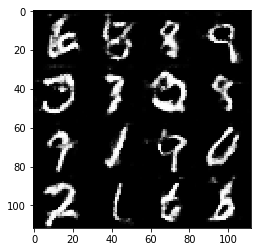

Epoch 2/2... Discriminator Loss: 1.0198... Generator Loss: 0.8109
Epoch 2/2... Discriminator Loss: 1.2309... Generator Loss: 1.3905
Epoch 2/2... Discriminator Loss: 1.0977... Generator Loss: 1.7798
Epoch 2/2... Discriminator Loss: 1.2465... Generator Loss: 0.5895
Epoch 2/2... Discriminator Loss: 0.9176... Generator Loss: 0.9286
Epoch 2/2... Discriminator Loss: 1.4380... Generator Loss: 0.5168
Epoch 2/2... Discriminator Loss: 1.0545... Generator Loss: 1.3512
Epoch 2/2... Discriminator Loss: 1.0551... Generator Loss: 0.7892
Epoch 2/2... Discriminator Loss: 1.0332... Generator Loss: 0.8333
Epoch 2/2... Discriminator Loss: 1.3734... Generator Loss: 0.5241


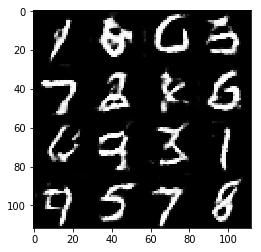

Epoch 2/2... Discriminator Loss: 1.0869... Generator Loss: 0.8020
Epoch 2/2... Discriminator Loss: 0.9976... Generator Loss: 1.1264
Epoch 2/2... Discriminator Loss: 1.1083... Generator Loss: 0.8369
Epoch 2/2... Discriminator Loss: 1.1216... Generator Loss: 0.7467
Epoch 2/2... Discriminator Loss: 1.0135... Generator Loss: 0.9414
Epoch 2/2... Discriminator Loss: 1.1099... Generator Loss: 0.7868
Epoch 2/2... Discriminator Loss: 1.4426... Generator Loss: 0.5066
Epoch 2/2... Discriminator Loss: 1.1162... Generator Loss: 0.7617
Epoch 2/2... Discriminator Loss: 1.0778... Generator Loss: 0.7849
Epoch 2/2... Discriminator Loss: 1.5136... Generator Loss: 0.4728


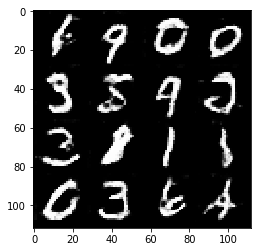

Epoch 2/2... Discriminator Loss: 1.2507... Generator Loss: 0.6119
Epoch 2/2... Discriminator Loss: 1.5775... Generator Loss: 0.4129
Epoch 2/2... Discriminator Loss: 0.9751... Generator Loss: 0.9142
Epoch 2/2... Discriminator Loss: 0.9931... Generator Loss: 0.8518
Epoch 2/2... Discriminator Loss: 1.2655... Generator Loss: 0.6019
Epoch 2/2... Discriminator Loss: 0.9750... Generator Loss: 0.8762
Epoch 2/2... Discriminator Loss: 1.5092... Generator Loss: 0.5114
Epoch 2/2... Discriminator Loss: 0.9940... Generator Loss: 0.9048
Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 0.9516
Epoch 2/2... Discriminator Loss: 1.1154... Generator Loss: 0.7305


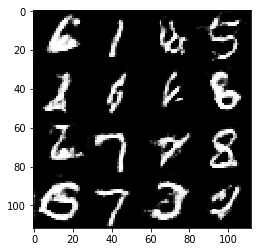

Epoch 2/2... Discriminator Loss: 1.2636... Generator Loss: 0.5947
Epoch 2/2... Discriminator Loss: 1.2237... Generator Loss: 0.6094
Epoch 2/2... Discriminator Loss: 1.2859... Generator Loss: 0.5825
Epoch 2/2... Discriminator Loss: 1.2324... Generator Loss: 0.6374
Epoch 2/2... Discriminator Loss: 1.6677... Generator Loss: 0.3914
Epoch 2/2... Discriminator Loss: 0.8405... Generator Loss: 1.2854
Epoch 2/2... Discriminator Loss: 0.8590... Generator Loss: 1.1004
Epoch 2/2... Discriminator Loss: 0.8497... Generator Loss: 1.1004
Epoch 2/2... Discriminator Loss: 1.4764... Generator Loss: 0.4993
Epoch 2/2... Discriminator Loss: 1.2994... Generator Loss: 0.5792


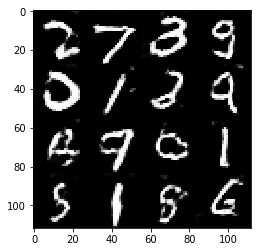

Epoch 2/2... Discriminator Loss: 1.7652... Generator Loss: 0.3368
Epoch 2/2... Discriminator Loss: 1.2147... Generator Loss: 0.6405
Epoch 2/2... Discriminator Loss: 0.8434... Generator Loss: 1.2972
Epoch 2/2... Discriminator Loss: 1.0811... Generator Loss: 1.7825
Epoch 2/2... Discriminator Loss: 0.9034... Generator Loss: 1.1490
Epoch 2/2... Discriminator Loss: 0.8863... Generator Loss: 1.1099
Epoch 2/2... Discriminator Loss: 1.0130... Generator Loss: 0.8913
Epoch 2/2... Discriminator Loss: 1.4879... Generator Loss: 0.4474
Epoch 2/2... Discriminator Loss: 1.5046... Generator Loss: 0.4408
Epoch 2/2... Discriminator Loss: 1.2686... Generator Loss: 0.6217


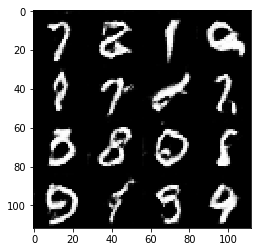

Epoch 2/2... Discriminator Loss: 0.9413... Generator Loss: 1.0138
Epoch 2/2... Discriminator Loss: 1.2019... Generator Loss: 1.7730
Epoch 2/2... Discriminator Loss: 0.9968... Generator Loss: 0.9334
Epoch 2/2... Discriminator Loss: 0.7416... Generator Loss: 2.0257
Epoch 2/2... Discriminator Loss: 0.9295... Generator Loss: 1.0648
Epoch 2/2... Discriminator Loss: 0.7784... Generator Loss: 1.2442
Epoch 2/2... Discriminator Loss: 0.7997... Generator Loss: 1.1962
Epoch 2/2... Discriminator Loss: 2.1236... Generator Loss: 0.2316
Epoch 2/2... Discriminator Loss: 0.9558... Generator Loss: 0.9041
Epoch 2/2... Discriminator Loss: 1.8278... Generator Loss: 2.9106


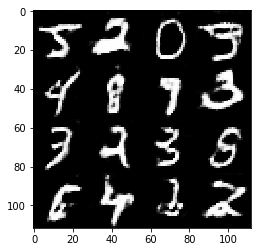

Epoch 2/2... Discriminator Loss: 1.2634... Generator Loss: 0.5679
Epoch 2/2... Discriminator Loss: 0.9215... Generator Loss: 1.0723
Epoch 2/2... Discriminator Loss: 1.3093... Generator Loss: 0.5722
Epoch 2/2... Discriminator Loss: 0.8611... Generator Loss: 1.7271
Epoch 2/2... Discriminator Loss: 0.7114... Generator Loss: 1.5039
Epoch 2/2... Discriminator Loss: 1.6697... Generator Loss: 0.3956
Epoch 2/2... Discriminator Loss: 1.2024... Generator Loss: 0.6366
Epoch 2/2... Discriminator Loss: 0.9261... Generator Loss: 0.9127
Epoch 2/2... Discriminator Loss: 2.1349... Generator Loss: 3.3320
Epoch 2/2... Discriminator Loss: 0.9191... Generator Loss: 1.0889


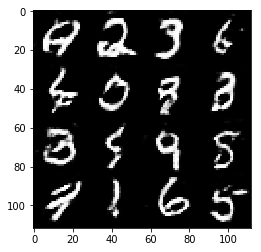

Epoch 2/2... Discriminator Loss: 0.7089... Generator Loss: 1.4569
Epoch 2/2... Discriminator Loss: 1.0010... Generator Loss: 0.8311
Epoch 2/2... Discriminator Loss: 0.7234... Generator Loss: 1.3180
Epoch 2/2... Discriminator Loss: 0.6414... Generator Loss: 1.8259
Epoch 2/2... Discriminator Loss: 1.1291... Generator Loss: 2.0493
Epoch 2/2... Discriminator Loss: 0.8198... Generator Loss: 1.2728
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.5370


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.3056... Generator Loss: 0.2597
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 1.6634
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.6524... Generator Loss: 1.1445
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 2.4504
Epoch 1/1... Discriminator Loss: 1.8595... Generator Loss: 0.3199
Epoch 1/1... Discriminator Loss: 1.5740... Generator Loss: 0.4131
Epoch 1/1... Discriminator Loss: 1.5947... Generator Loss: 0.4336
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.6129... Generator Loss: 0.3833


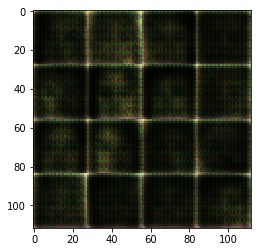

Epoch 1/1... Discriminator Loss: 1.7533... Generator Loss: 0.3282
Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.4824
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.4877
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.5262
Epoch 1/1... Discriminator Loss: 2.2638... Generator Loss: 0.2029
Epoch 1/1... Discriminator Loss: 2.7882... Generator Loss: 0.1160
Epoch 1/1... Discriminator Loss: 1.6310... Generator Loss: 0.3591
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 1.6808
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 0.4712... Generator Loss: 3.2068


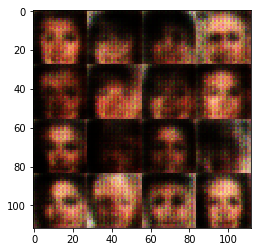

Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 1.9360
Epoch 1/1... Discriminator Loss: 0.6443... Generator Loss: 2.4449
Epoch 1/1... Discriminator Loss: 2.2477... Generator Loss: 0.1838
Epoch 1/1... Discriminator Loss: 1.7563... Generator Loss: 0.3209
Epoch 1/1... Discriminator Loss: 1.9700... Generator Loss: 0.2521
Epoch 1/1... Discriminator Loss: 1.8693... Generator Loss: 0.3318
Epoch 1/1... Discriminator Loss: 0.6605... Generator Loss: 1.5718
Epoch 1/1... Discriminator Loss: 0.7487... Generator Loss: 1.6278
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 1.5174
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.7256


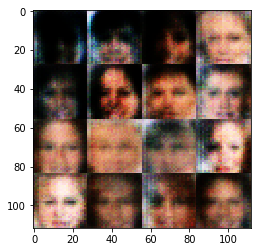

Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 0.4335
Epoch 1/1... Discriminator Loss: 1.7743... Generator Loss: 0.3135
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 2.7531
Epoch 1/1... Discriminator Loss: 0.6494... Generator Loss: 1.8068
Epoch 1/1... Discriminator Loss: 0.7898... Generator Loss: 4.4809
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 3.3939
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.4531
Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 4.9951
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.6780


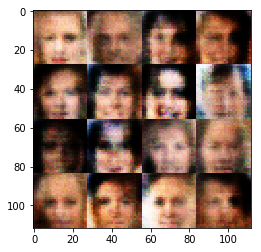

Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 3.6323
Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 1.1342
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.5915... Generator Loss: 0.3742
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 1.6116
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 1.0385
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 0.6009... Generator Loss: 2.3926
Epoch 1/1... Discriminator Loss: 0.7653... Generator Loss: 1.1687
Epoch 1/1... Discriminator Loss: 0.6174... Generator Loss: 1.7112


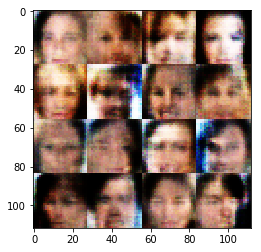

Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 1.2038
Epoch 1/1... Discriminator Loss: 0.5356... Generator Loss: 2.3726
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 1.7251
Epoch 1/1... Discriminator Loss: 0.8692... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 0.8703... Generator Loss: 3.6935


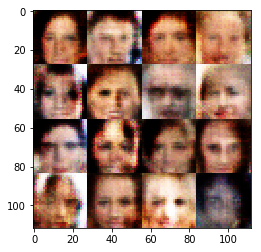

Epoch 1/1... Discriminator Loss: 0.6962... Generator Loss: 2.6686
Epoch 1/1... Discriminator Loss: 0.4273... Generator Loss: 3.3773
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 3.7686
Epoch 1/1... Discriminator Loss: 0.4815... Generator Loss: 2.3301
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 2.0755... Generator Loss: 2.3739
Epoch 1/1... Discriminator Loss: 0.5795... Generator Loss: 3.1257
Epoch 1/1... Discriminator Loss: 0.6158... Generator Loss: 4.1832
Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 4.1057
Epoch 1/1... Discriminator Loss: 1.6164... Generator Loss: 3.6182


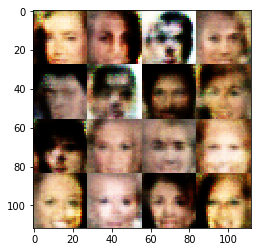

Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 4.4053
Epoch 1/1... Discriminator Loss: 0.6068... Generator Loss: 2.3872
Epoch 1/1... Discriminator Loss: 0.7168... Generator Loss: 4.0035
Epoch 1/1... Discriminator Loss: 0.5194... Generator Loss: 2.0409
Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 2.1348
Epoch 1/1... Discriminator Loss: 0.5580... Generator Loss: 5.8295
Epoch 1/1... Discriminator Loss: 0.6381... Generator Loss: 1.5462
Epoch 1/1... Discriminator Loss: 0.4311... Generator Loss: 3.5196
Epoch 1/1... Discriminator Loss: 0.4328... Generator Loss: 2.7530
Epoch 1/1... Discriminator Loss: 0.4630... Generator Loss: 2.7277


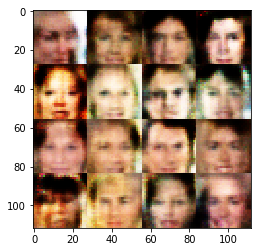

Epoch 1/1... Discriminator Loss: 0.6807... Generator Loss: 1.3847
Epoch 1/1... Discriminator Loss: 0.4399... Generator Loss: 4.0009
Epoch 1/1... Discriminator Loss: 0.4813... Generator Loss: 2.2327
Epoch 1/1... Discriminator Loss: 0.4451... Generator Loss: 2.7085
Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 1.0929
Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 0.4755... Generator Loss: 3.2422
Epoch 1/1... Discriminator Loss: 0.4508... Generator Loss: 3.2871
Epoch 1/1... Discriminator Loss: 0.5603... Generator Loss: 1.7521
Epoch 1/1... Discriminator Loss: 0.5142... Generator Loss: 2.0367


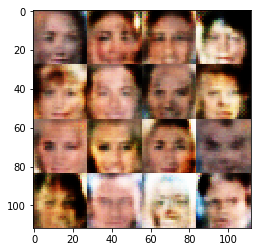

Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 3.0967
Epoch 1/1... Discriminator Loss: 0.5221... Generator Loss: 2.8832
Epoch 1/1... Discriminator Loss: 0.3972... Generator Loss: 4.2220
Epoch 1/1... Discriminator Loss: 0.4423... Generator Loss: 4.4809
Epoch 1/1... Discriminator Loss: 0.4738... Generator Loss: 3.1490
Epoch 1/1... Discriminator Loss: 0.4137... Generator Loss: 3.1792
Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 3.7880
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 4.9227
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 3.5677
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 4.0076


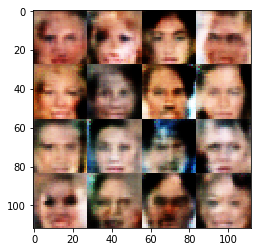

Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 5.5001
Epoch 1/1... Discriminator Loss: 0.4369... Generator Loss: 3.5029
Epoch 1/1... Discriminator Loss: 0.4568... Generator Loss: 3.5150
Epoch 1/1... Discriminator Loss: 0.3867... Generator Loss: 4.1281
Epoch 1/1... Discriminator Loss: 0.4396... Generator Loss: 2.5893
Epoch 1/1... Discriminator Loss: 0.4794... Generator Loss: 2.4477
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 4.4949
Epoch 1/1... Discriminator Loss: 2.0808... Generator Loss: 5.0917
Epoch 1/1... Discriminator Loss: 0.4706... Generator Loss: 3.5910
Epoch 1/1... Discriminator Loss: 0.4925... Generator Loss: 2.4321


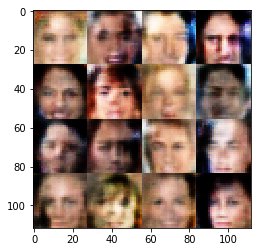

Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 3.9674
Epoch 1/1... Discriminator Loss: 0.6314... Generator Loss: 3.8379
Epoch 1/1... Discriminator Loss: 0.7425... Generator Loss: 3.5734
Epoch 1/1... Discriminator Loss: 0.5555... Generator Loss: 1.8077
Epoch 1/1... Discriminator Loss: 0.6094... Generator Loss: 4.3000
Epoch 1/1... Discriminator Loss: 0.3890... Generator Loss: 3.7031
Epoch 1/1... Discriminator Loss: 0.4075... Generator Loss: 3.2067
Epoch 1/1... Discriminator Loss: 2.8486... Generator Loss: 0.1042
Epoch 1/1... Discriminator Loss: 0.5449... Generator Loss: 1.9888
Epoch 1/1... Discriminator Loss: 0.4353... Generator Loss: 3.4833


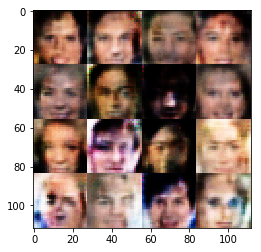

Epoch 1/1... Discriminator Loss: 0.4110... Generator Loss: 3.3988
Epoch 1/1... Discriminator Loss: 2.3793... Generator Loss: 3.9564
Epoch 1/1... Discriminator Loss: 0.4538... Generator Loss: 2.9991
Epoch 1/1... Discriminator Loss: 0.4052... Generator Loss: 3.3400
Epoch 1/1... Discriminator Loss: 0.7206... Generator Loss: 1.4073
Epoch 1/1... Discriminator Loss: 0.5909... Generator Loss: 4.0809
Epoch 1/1... Discriminator Loss: 0.5436... Generator Loss: 1.9154
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 0.4330... Generator Loss: 3.2253
Epoch 1/1... Discriminator Loss: 0.4716... Generator Loss: 2.3139


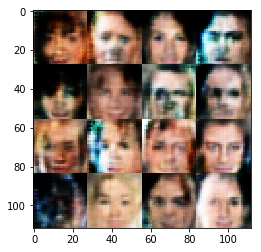

Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 3.4212
Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 1.9915
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 3.0414
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 3.0154
Epoch 1/1... Discriminator Loss: 2.4911... Generator Loss: 3.4244
Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 1.3986
Epoch 1/1... Discriminator Loss: 0.5591... Generator Loss: 2.6377
Epoch 1/1... Discriminator Loss: 0.5907... Generator Loss: 1.7096
Epoch 1/1... Discriminator Loss: 0.5519... Generator Loss: 1.7965
Epoch 1/1... Discriminator Loss: 0.4901... Generator Loss: 3.5497


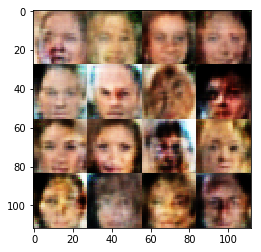

Epoch 1/1... Discriminator Loss: 0.5758... Generator Loss: 1.8231
Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 2.4811
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 1.8276
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 0.4200... Generator Loss: 2.9210
Epoch 1/1... Discriminator Loss: 0.4168... Generator Loss: 3.5842
Epoch 1/1... Discriminator Loss: 0.4561... Generator Loss: 2.4505
Epoch 1/1... Discriminator Loss: 0.4651... Generator Loss: 2.4777
Epoch 1/1... Discriminator Loss: 0.3781... Generator Loss: 4.0365
Epoch 1/1... Discriminator Loss: 0.4368... Generator Loss: 2.7061


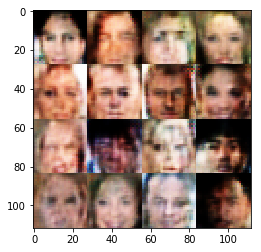

Epoch 1/1... Discriminator Loss: 0.4431... Generator Loss: 2.6094
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 3.4466
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 3.0080
Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 1.9999
Epoch 1/1... Discriminator Loss: 0.7785... Generator Loss: 1.2106
Epoch 1/1... Discriminator Loss: 0.4776... Generator Loss: 2.5787
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.4894
Epoch 1/1... Discriminator Loss: 0.5280... Generator Loss: 2.8964
Epoch 1/1... Discriminator Loss: 0.5150... Generator Loss: 3.3746
Epoch 1/1... Discriminator Loss: 0.4739... Generator Loss: 2.9341


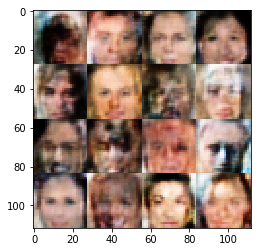

Epoch 1/1... Discriminator Loss: 0.4317... Generator Loss: 3.3915
Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 3.3208
Epoch 1/1... Discriminator Loss: 1.7506... Generator Loss: 3.8158
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 2.7573
Epoch 1/1... Discriminator Loss: 0.7491... Generator Loss: 2.9254
Epoch 1/1... Discriminator Loss: 0.6927... Generator Loss: 3.5268
Epoch 1/1... Discriminator Loss: 0.4308... Generator Loss: 2.9213
Epoch 1/1... Discriminator Loss: 0.7477... Generator Loss: 4.4148
Epoch 1/1... Discriminator Loss: 0.4611... Generator Loss: 3.2820
Epoch 1/1... Discriminator Loss: 0.4663... Generator Loss: 2.3785


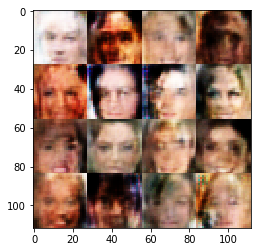

Epoch 1/1... Discriminator Loss: 0.7999... Generator Loss: 3.9317
Epoch 1/1... Discriminator Loss: 2.1882... Generator Loss: 3.7518
Epoch 1/1... Discriminator Loss: 0.6004... Generator Loss: 1.7813
Epoch 1/1... Discriminator Loss: 0.5664... Generator Loss: 1.9831
Epoch 1/1... Discriminator Loss: 0.5541... Generator Loss: 2.1232
Epoch 1/1... Discriminator Loss: 0.3907... Generator Loss: 4.2967
Epoch 1/1... Discriminator Loss: 0.6080... Generator Loss: 3.5233
Epoch 1/1... Discriminator Loss: 0.5660... Generator Loss: 1.8107
Epoch 1/1... Discriminator Loss: 0.5016... Generator Loss: 2.5544
Epoch 1/1... Discriminator Loss: 0.5083... Generator Loss: 2.1528


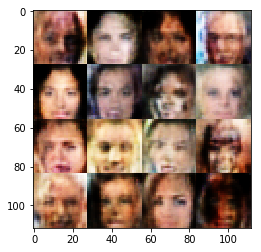

Epoch 1/1... Discriminator Loss: 0.4856... Generator Loss: 3.8750
Epoch 1/1... Discriminator Loss: 0.4526... Generator Loss: 3.1895
Epoch 1/1... Discriminator Loss: 0.4380... Generator Loss: 2.6611
Epoch 1/1... Discriminator Loss: 0.4726... Generator Loss: 3.1370
Epoch 1/1... Discriminator Loss: 0.4387... Generator Loss: 2.6968
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.2936
Epoch 1/1... Discriminator Loss: 0.5528... Generator Loss: 1.8833
Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 1.3742


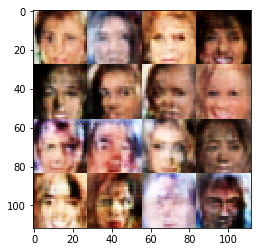

Epoch 1/1... Discriminator Loss: 0.6573... Generator Loss: 1.5010
Epoch 1/1... Discriminator Loss: 0.5607... Generator Loss: 1.8784
Epoch 1/1... Discriminator Loss: 0.3822... Generator Loss: 3.3731
Epoch 1/1... Discriminator Loss: 0.6248... Generator Loss: 3.4332
Epoch 1/1... Discriminator Loss: 0.5845... Generator Loss: 1.7111
Epoch 1/1... Discriminator Loss: 0.4397... Generator Loss: 2.7184
Epoch 1/1... Discriminator Loss: 1.6403... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.1393
Epoch 1/1... Discriminator Loss: 0.6827... Generator Loss: 1.4039
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 1.1394


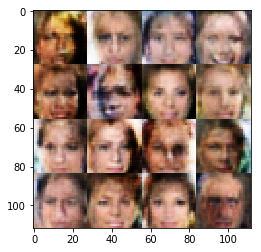

Epoch 1/1... Discriminator Loss: 0.5726... Generator Loss: 2.0556
Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 3.2462
Epoch 1/1... Discriminator Loss: 0.4572... Generator Loss: 2.9067
Epoch 1/1... Discriminator Loss: 0.5758... Generator Loss: 2.3450
Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 1.8614
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 1.2120
Epoch 1/1... Discriminator Loss: 0.4752... Generator Loss: 2.6890
Epoch 1/1... Discriminator Loss: 0.4276... Generator Loss: 3.0522
Epoch 1/1... Discriminator Loss: 0.4830... Generator Loss: 2.8363
Epoch 1/1... Discriminator Loss: 0.3967... Generator Loss: 3.3505


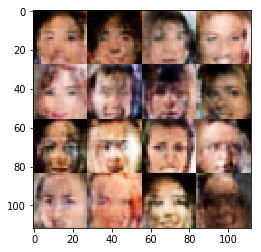

Epoch 1/1... Discriminator Loss: 0.5209... Generator Loss: 3.3212
Epoch 1/1... Discriminator Loss: 0.4850... Generator Loss: 2.2118
Epoch 1/1... Discriminator Loss: 0.3707... Generator Loss: 4.1292
Epoch 1/1... Discriminator Loss: 0.4074... Generator Loss: 2.9524
Epoch 1/1... Discriminator Loss: 1.6863... Generator Loss: 2.1442
Epoch 1/1... Discriminator Loss: 0.6014... Generator Loss: 2.1751
Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 1.5692
Epoch 1/1... Discriminator Loss: 0.6664... Generator Loss: 1.3874
Epoch 1/1... Discriminator Loss: 0.7015... Generator Loss: 4.2075


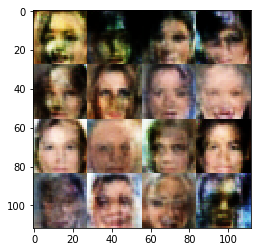

Epoch 1/1... Discriminator Loss: 0.5091... Generator Loss: 2.0450
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 3.1445
Epoch 1/1... Discriminator Loss: 0.4837... Generator Loss: 2.4035
Epoch 1/1... Discriminator Loss: 0.4344... Generator Loss: 2.5681
Epoch 1/1... Discriminator Loss: 0.3999... Generator Loss: 3.0834
Epoch 1/1... Discriminator Loss: 0.4281... Generator Loss: 2.7735
Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 2.4284
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 1.1374
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.9435


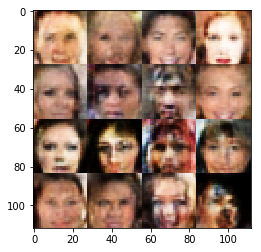

Epoch 1/1... Discriminator Loss: 0.5989... Generator Loss: 1.6125
Epoch 1/1... Discriminator Loss: 0.5602... Generator Loss: 1.9256
Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 0.5782... Generator Loss: 3.9233
Epoch 1/1... Discriminator Loss: 0.4849... Generator Loss: 2.2061
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 0.4549... Generator Loss: 3.4983
Epoch 1/1... Discriminator Loss: 0.5105... Generator Loss: 3.1231
Epoch 1/1... Discriminator Loss: 0.5169... Generator Loss: 2.2699
Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 1.2574


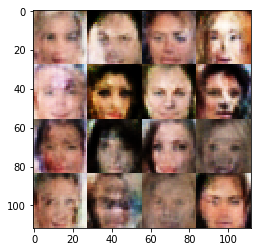

Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 0.4436... Generator Loss: 2.6024
Epoch 1/1... Discriminator Loss: 0.5909... Generator Loss: 1.6848
Epoch 1/1... Discriminator Loss: 0.5612... Generator Loss: 3.5799
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 1.8251
Epoch 1/1... Discriminator Loss: 0.4642... Generator Loss: 2.4977
Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 2.0615
Epoch 1/1... Discriminator Loss: 0.4207... Generator Loss: 2.8643
Epoch 1/1... Discriminator Loss: 2.9725... Generator Loss: 0.1143
Epoch 1/1... Discriminator Loss: 0.9106... Generator Loss: 1.1005


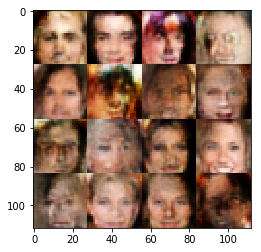

Epoch 1/1... Discriminator Loss: 0.4082... Generator Loss: 3.5062
Epoch 1/1... Discriminator Loss: 0.4977... Generator Loss: 2.9693
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 0.4566... Generator Loss: 4.1061
Epoch 1/1... Discriminator Loss: 0.6145... Generator Loss: 3.0342
Epoch 1/1... Discriminator Loss: 0.4661... Generator Loss: 2.6308
Epoch 1/1... Discriminator Loss: 0.3742... Generator Loss: 3.7877
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 0.7535... Generator Loss: 1.2196


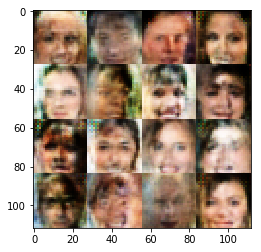

Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 1.9616
Epoch 1/1... Discriminator Loss: 0.6166... Generator Loss: 1.6165
Epoch 1/1... Discriminator Loss: 0.4902... Generator Loss: 2.9297
Epoch 1/1... Discriminator Loss: 0.5706... Generator Loss: 1.7707
Epoch 1/1... Discriminator Loss: 0.4645... Generator Loss: 2.3267
Epoch 1/1... Discriminator Loss: 2.2906... Generator Loss: 3.3328
Epoch 1/1... Discriminator Loss: 0.5828... Generator Loss: 2.1639
Epoch 1/1... Discriminator Loss: 0.5575... Generator Loss: 2.1912
Epoch 1/1... Discriminator Loss: 0.4043... Generator Loss: 3.0147
Epoch 1/1... Discriminator Loss: 0.4661... Generator Loss: 2.3411


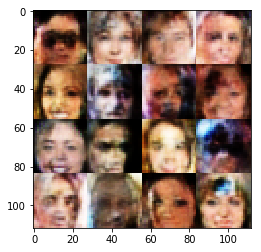

Epoch 1/1... Discriminator Loss: 0.3920... Generator Loss: 3.2007
Epoch 1/1... Discriminator Loss: 0.3950... Generator Loss: 3.2465
Epoch 1/1... Discriminator Loss: 0.6362... Generator Loss: 1.5777
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 0.5902... Generator Loss: 1.8161
Epoch 1/1... Discriminator Loss: 0.7097... Generator Loss: 2.9738
Epoch 1/1... Discriminator Loss: 0.4991... Generator Loss: 2.6916
Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 1.8742
Epoch 1/1... Discriminator Loss: 0.7115... Generator Loss: 3.8378
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 1.0476


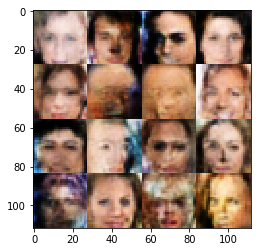

Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 0.5502... Generator Loss: 2.8248
Epoch 1/1... Discriminator Loss: 0.6265... Generator Loss: 1.5276
Epoch 1/1... Discriminator Loss: 0.3916... Generator Loss: 3.6418
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 0.7480... Generator Loss: 1.3670
Epoch 1/1... Discriminator Loss: 0.5204... Generator Loss: 2.0854
Epoch 1/1... Discriminator Loss: 0.3858... Generator Loss: 3.9257
Epoch 1/1... Discriminator Loss: 0.4503... Generator Loss: 3.6272
Epoch 1/1... Discriminator Loss: 0.4333... Generator Loss: 2.7753


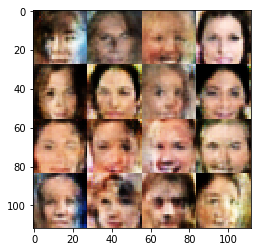

Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.5177
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 2.5984
Epoch 1/1... Discriminator Loss: 0.3563... Generator Loss: 5.6186
Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 0.4164... Generator Loss: 3.2023
Epoch 1/1... Discriminator Loss: 0.4011... Generator Loss: 3.5570
Epoch 1/1... Discriminator Loss: 0.4687... Generator Loss: 2.4476
Epoch 1/1... Discriminator Loss: 0.8802... Generator Loss: 1.8289
Epoch 1/1... Discriminator Loss: 0.4864... Generator Loss: 2.3169
Epoch 1/1... Discriminator Loss: 0.4133... Generator Loss: 5.5451


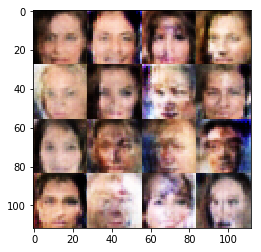

Epoch 1/1... Discriminator Loss: 0.5073... Generator Loss: 4.4085
Epoch 1/1... Discriminator Loss: 2.1402... Generator Loss: 3.5627
Epoch 1/1... Discriminator Loss: 0.5605... Generator Loss: 1.9616
Epoch 1/1... Discriminator Loss: 0.6738... Generator Loss: 2.0916
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 1.7741
Epoch 1/1... Discriminator Loss: 0.5144... Generator Loss: 2.4575
Epoch 1/1... Discriminator Loss: 0.6010... Generator Loss: 1.6574
Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 3.4494
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 1.4457
Epoch 1/1... Discriminator Loss: 0.4480... Generator Loss: 3.0938


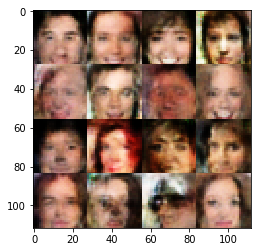

Epoch 1/1... Discriminator Loss: 0.4773... Generator Loss: 3.8293
Epoch 1/1... Discriminator Loss: 0.7492... Generator Loss: 1.6643
Epoch 1/1... Discriminator Loss: 0.5322... Generator Loss: 2.3285
Epoch 1/1... Discriminator Loss: 0.5288... Generator Loss: 1.9144
Epoch 1/1... Discriminator Loss: 0.4710... Generator Loss: 2.3037
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 0.6937


In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.